In this exercise, we will be extending our neural network to build a sentiment classification model. When I took my first machine learning class, our professor specialized in text data predictive modelling and taught us a wide breadth of methods to deal with feature engineering and model construction. Although Google's crash course does not touch on many of these topics, I will be (for the sake of rigor and for the readers own enjoyment). Take from it what you will as it will be sprinkled across this notebook. 

We will be using movie review data from IMDB and explore sparse data and embeddings

### Setup

In [1]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

from IPython import display
from sklearn import metrics


tf.logging.set_verbosity(tf.logging.ERROR)
#import datasets
train_url = 'https://dl.google.com/mlcc/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://dl.google.com/mlcc/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)


### Sentiment Analysis Model & Building the Input Pipeline

The purpose of the sentiment analysis model will be to predict if a given IMDB review is positive (label of 1) or negative. The question is though, how do we feed a block of text into a neural network? 

We do this by determining a *vocabulary* of terms (terms we want to support in the classification task), taking commonly used or informative words (this will be dataset dependent). Any terms not in our *vocabulary* are ignored. Once we have this vocabulary, we can represent a single word by an $N$ length binary fectory with exactly one $1$:

$$\text{apple} \rightarrow [0,0,0,\ldots,0,1,0,\ldots,0]$$

It is essentially a one-hot representation. We will be doing this when using LinearClassifier and DNN ('sparse inputs and explicit vocabulary')

Now, lets configure the input pipeline to import the data into TF. The following function will parse the training & test data and return a dict of features and corresponding labels

In [2]:
"""Extracts features and labels from training and test data

    Args:
        record: File path to TFRecord file (what we imported earlier)
    Returns:
        A 'tuple' (labels, features):
            features: Dict of tensors representing features 
            labels: Tensor with corresponding label of feature (0,1)
"""
def _parse_function(record):
    
    features = {
        #datatype of terms are variable length strings, labels are either 0 or 1. 
        "terms": tf.VarLenFeature(dtype=tf.string),
        "labels": tf.FixedLenFeature(shape = [1], dtype = tf.float32)
    }
    
    parsed_features = tf.parse_single_example(record, features)
    
    terms = parsed_features['terms'].values
    labels = parsed_features['labels']
    
    return {'terms':terms}, labels
    

Lets take a look at the data to make sure the function works fine and retrieve the first example of the training data. 

In [3]:
#creates dataset object
ds = tf.data.TFRecordDataset(train_path)
#uses the function above to extract features and labels
ds = ds.map(_parse_function)
ds

#Receives first example from training data
n = ds.make_one_shot_iterator().get_next()
session = tf.Session()
session.run(n)



({'terms': array(['but', 'it', 'does', 'have', 'some', 'good', 'action', 'and', 'a',
         'plot', 'that', 'is', 'somewhat', 'interesting', '.', 'nevsky',
         'acts', 'like', 'a', 'body', 'builder', 'and', 'he', 'isn', "'",
         't', 'all', 'that', 'attractive', ',', 'in', 'fact', ',', 'imo',
         ',', 'he', 'is', 'ugly', '.', '(', 'his', 'acting', 'skills',
         'lack', 'everything', '!', ')', 'sascha', 'is', 'played', 'very',
         'well', 'by', 'joanna', 'pacula', ',', 'but', 'she', 'needed',
         'more', 'lines', 'than', 'she', 'was', 'given', ',', 'her',
         'character', 'needed', 'to', 'be', 'developed', '.', 'there',
         'are', 'way', 'too', 'many', 'men', 'in', 'this', 'story', ',',
         'there', 'is', 'zero', 'romance', ',', 'too', 'much', 'action',
         ',', 'and', 'way', 'too', 'dumb', 'of', 'an', 'ending', '.', 'it',
         'is', 'very', 'violent', '.', 'i', 'did', 'however', 'love', 'the',
         'scenery', ',', 'this', 'mov

Alright, everything looks as expected. One last thing to do is build an input function to pass to TF and train our model

In [4]:
"""Custom input function to parse the examples and split into features and targets

    Args:
        input_filenames: filepath of training data
    Returns:
        features: Dict of tensors representing features 
        labels: Tensor with corresponding label of feature (0,1)

"""
def _input_func(input_filenames, num_epochs = None, shuffle = True):
    
    #creates dataset and maps features to labels
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    #pad and batch each field of dataset to whatever size necessary (since variable length strings)
    ds = ds.padded_batch(25, ds.output_shapes)
    ds = ds.repeat(num_epochs)
    
    #return next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### First things first...

Let's try our hand at a LinearClassifier model using 50 terms in our vocabulary listed below. This code will construct feature columns for our terms, train and evaluate our model. (NOTE: We are not usings embeddings JUST yet, we will later on in the notebook) 

In [5]:
#Our 'vocabulary' explicit terms we pass to TF using one hot encoding
informative_terms = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")

terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key = "terms", 
                                                                                 vocabulary_list = informative_terms)

In [6]:
#define optimizer and feature columns
my_optimizer = tf.train.AdagradOptimizer(learning_rate = 0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

feature_columns = [terms_feature_column]


#define and train Linear classifier 
classifier = tf.estimator.LinearClassifier(
    feature_columns = feature_columns,
    optimizer = my_optimizer
)

classifier.train(
    input_fn = lambda: _input_func([train_path]),
    steps = 1000
)



#compute and print training set metrics
evaluation_metrics = classifier.evaluate(
    input_fn = lambda: _input_func([train_path]),
    steps = 1000
)

print("Training set metrics: ")
for m in evaluation_metrics:
    
    print(m,evaluation_metrics[m])
print("---")


#compute and print test set metrics
evaluation_metrics = classifier.evaluate(
    input_fn = lambda: _input_func([test_path]),
    steps = 1000
)

print("Test set metrics:")
for m in evaluation_metrics:
    
    print(m,evaluation_metrics[m])
print("---")


Training set metrics: 
loss 11.2722435
accuracy_baseline 0.5
global_step 1000
recall 0.8568
auc 0.87176853
prediction/mean 0.5160384
precision 0.7539599
label/mean 0.5
average_loss 0.45088974
auc_precision_recall 0.861798
accuracy 0.7886
---
Test set metrics:
loss 11.280082
accuracy_baseline 0.5
global_step 1000
recall 0.8516
auc 0.8703351
prediction/mean 0.51421326
precision 0.7520311
label/mean 0.5
average_loss 0.4512033
auc_precision_recall 0.8598566
accuracy 0.7854
---


78% accuracy does quite well, especially with an AUC of 0.85. 

### Deeper (and Stronger?)

Can we do better with a DNN? 

In [8]:
#define and train DNN classifier
classifier = tf.estimator.DNNClassifier(
    feature_columns = [tf.feature_column.indicator_column(terms_feature_column)],
    hidden_units = [32,32],
    optimizer = my_optimizer)

try:
    #train linear classifier 
    classifier.train(
        input_fn = lambda: _input_func([train_path]),
        steps = 1000
    )
    
    
    #compute and print training set metrics
    evaluation_metrics = classifier.evaluate(
        input_fn = lambda: _input_func([train_path]),
        steps = 1
    )
    
    print("Training set metrics: ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    
    #compute and print test set metrics
    evaluation_metrics = classifier.evaluate(
        input_fn = lambda: _input_func([test_path]),
        steps = 1
    )
    
    print("Test set metrics:  ")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
except ValueError as err:
    print(err)
    

Training set metrics: 
loss 12.851398
accuracy_baseline 0.64
global_step 1000
recall 1.0
auc 0.86805546
prediction/mean 0.52324325
precision 0.6
label/mean 0.36
average_loss 0.51405597
auc_precision_recall 0.7041963
accuracy 0.76
---
Test set metrics:  
loss 8.931396
accuracy_baseline 0.52
global_step 1000
recall 0.84615386
auc 0.9326923
prediction/mean 0.5243819
precision 0.78571427
label/mean 0.52
average_loss 0.35725582
auc_precision_recall 0.93896323
accuracy 0.8
---


So we definitely do alot better using 2 hidden layers with 32 neurons in each (albeit I arrived at this solution naively). We also see a better AUC at .88 on the test set, but do note the overfitting occuring as our training set metrics are much higher than our test metrics. (Note: Since the initialization of the weighting scheme for the neural networks under using the TF.Estimator API is random, the results will not be the same run to run; in fact it is highly unlikely you will get the same results as I do). 

### Embeddings

So, now we come to embeddings. Before moving on, I do want to spend a bit of time deconstructing what an embedding actually is and how to interpret them. 

The whole idea behind an embedding is to map a word as a vector in p-dimensional space (where p represents the number of embeddings we have):

$$ f(\text{word}) \rightarrow \mathbb{R}^p $$ 

The main takeaway we need to understand about embeddings is this: They provide a solution to the sparse one-hot representation we used previously. It does this by translating the sparse vectors (that we constructed with 'vocabulary' terms) into a lower dimensional p-space in an attempt to preserve semantic relationships. Lets see what I mean with a simple example below. 

#### Simple Example

Let's assume that we have the following word embeddings:

$$ \begin{align}
\text{the} &\rightarrow [1,0,0] \\
\text{cat} &\rightarrow [0,0.9,0]  \\
\text{is} &\rightarrow [0.8,0,0]  \\
\text{in} &\rightarrow [0.8,0,0]  \\
\text{and} &\rightarrow [1,0,0]  \\
\text{hat} &\rightarrow [0,0,0.75] \\
\text{sweater} &\rightarrow [0,0,0.9]
\end{align}$$

In this example we have a three-dimensional embedding; the first
component indicates whether this a common function word (article,
preposition, conj, etc.), the second whether its an animal, and the
third whether it is an article of clothing. We would map the
sentence:

- "The cat is in the hat and sweater"

To the array:

$$ \left[\begin{array}{ccc} 1 & 0 & 0 \\
                            0 & 0.9 & 0 \\
                            0.8 & 0 & 0 \\
                            0.8 & 0 & 0 \\
                            1 & 0 & 0 \\
                            0 & 0 & 0.75 \\
                            1 & 0 & 0 \\
                            0 & 0 & 0.9
                      \end{array}\right] $$

Now I'm sure you must be asking, "This seems great and all, we managed to avoid the curse of dimensionality, but how the **f#ck** did you get these embeddings?" Well, theres a couple of ways to automate this process. We can use PCA, word2vec, or better yet, pass our feature columns to Tensorflow's `embedding_column` so it'll do it for us automatically. 

Using an `embedding_column` is usually the computationally most efficient way to train a model on sparse data but there is something called an `indicator_column` we can also use that I will explore at the end of the exercise (for those interested). 

Below, we define our features using an `embedding_column` and run a similar DNNClassifier to the one above. 

In [28]:
#Tells TF to reduce the dimensionality of our terms_feature_column vectors to 
    #2 for each entry/word in our IMDB review
terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension = 2)
feature_columns = [terms_embedding_column]

my_optimizer = tf.train.AdagradOptimizer(learning_rate = 0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifier = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    hidden_units = [20,20],
    optimizer = my_optimizer)

#Train and evaluate training set metrics
classifier.train(
    input_fn = lambda: _input_func([train_path]),
    steps = 1000)

evaluation_metrics_train = classifier.evaluate(
    input_fn = lambda: _input_func([train_path]),
    steps = 1000)

print ("Training set metrics: ")
for m in evaluation_metrics_train:
    print(m, evaluation_metrics_train[m])
print("---")

#apply model to test set

evaluation_metrics_test = classifier.evaluate(
    input_fn = lambda: _input_func([test_path]),
    steps = 1000)

print("Test set metrics: ")
for m in evaluation_metrics_test:
    print(m, evaluation_metrics_test[m])
print("---")




Training set metrics: 
loss 11.381119
accuracy_baseline 0.5
global_step 1000
recall 0.7856
auc 0.86741364
prediction/mean 0.4843794
precision 0.7857257
label/mean 0.5
average_loss 0.45524478
auc_precision_recall 0.8561074
accuracy 0.78568
---
Test set metrics: 
loss 11.402009
accuracy_baseline 0.5
global_step 1000
recall 0.77912
auc 0.8668744
prediction/mean 0.48337987
precision 0.78477037
label/mean 0.5
average_loss 0.45608035
auc_precision_recall 0.85391784
accuracy 0.78272
---


So, we actually do pretty similar to our baseline DNN model based on our embeddings. But, we still want to find out whats going on internally. I do that below by taking a look at the tensors in the model. 

In [11]:
classifier.get_variable_names()

['dnn/hiddenlayer_0/bias',
 'dnn/hiddenlayer_0/bias/t_0/Adagrad',
 'dnn/hiddenlayer_0/kernel',
 'dnn/hiddenlayer_0/kernel/t_0/Adagrad',
 'dnn/hiddenlayer_1/bias',
 'dnn/hiddenlayer_1/bias/t_0/Adagrad',
 'dnn/hiddenlayer_1/kernel',
 'dnn/hiddenlayer_1/kernel/t_0/Adagrad',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights',
 'dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights/t_0/Adagrad',
 'dnn/logits/bias',
 'dnn/logits/bias/t_0/Adagrad',
 'dnn/logits/kernel',
 'dnn/logits/kernel/t_0/Adagrad',
 'global_step']

Above, we can get a better idea of what our neural network actually looks like (this should look really familiar to you keras users). We have an embedding layer that is trainable, just like any other hidden layer is. Is this layer the right dimension though?

We should expect to condense a 50 dimensional matrix into 2 dimensions like we specified above. 

In [12]:
classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights').shape

(50, 2)

If the results of the model are a bit irregular or prone to massive accuracy changes run to run, its always a good idea to manually check the shape of each layer to make sure everything is connected as expected. 

### Visualizing our Embedding

Now lets take a look at the actual embedding space and take a gander at where specific terms end up. The code below takes a look at the embedding we trained in the model above. The reason we're able to do this is because we collapsed our vector space into 2 dimensions, making it easy to graph. 

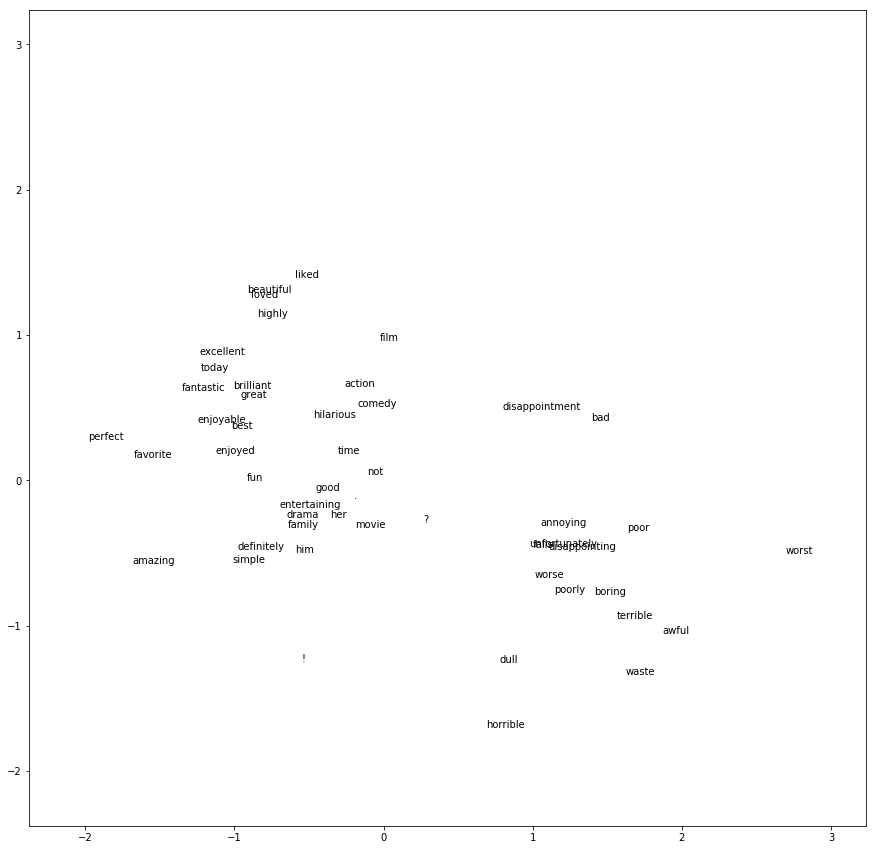

In [29]:
embedding_matrix = classifier.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for index in range(len(informative_terms)):
    
    #Creates one hot encoding for our term 
    term_vector = np.zeros(len(informative_terms))
    term_vector[index] = 1
    
    #project one hot encoding into embedding space
    embedding_xy = np.matmul(term_vector, embedding_matrix)
    
    plt.text(embedding_xy[0],
             embedding_xy[1],
             informative_terms[index])
    
#rescale plot
plt.rcParams["figure.figsize"] = (15,15)
plt.xlim(1.2*embedding_matrix.min(), 1.2*embedding_matrix.max())
plt.ylim(1.2*embedding_matrix.min(), 1.2*embedding_matrix.max())
plt.show()

So, at first glance, we can see a marked difference in words that connote bad meanings and words that connote good meanings that our embeddings have naturally captured the meaning of using just 2 dimensions. 

But note that if we run the model again, we may not get the same distribution of words along these 2 dimensions. What I mean to say is, from run to run, the exact locations of negative and positive words are unlikely to stay in the same areas. Since we are dealing with an unsupervised learner here, all it tries to do is seperate the vector space according to the characteristics of the words. The **way** it seperates these words however is random.  

### Final Exercises & Thoughts

This goes without saying but there are ways for the embedding model to be drastically improved. We can change the hyperparameters (such as the learning rate, hidden layer nodes or change the optimizer) but this is likely to only help our accuracy ever so slightly. 

Additionally, we can use the full list of informative terms instead just the 50 listed above. You can find the list [here]. (https://dl.google.com/mlcc/mledu-datasets/sparse-data-embedding/terms.txt)
 

So, you may have gotten(and probably did get) a DNN model that worked better than the linear model but do keep in mind scaling the problem up in size. Our linear model worked alot quicker, which may be sufficient depending on our use case. 

Its important to understand the applications and speed of the model architecture so we can pick a model that suits are needs. 

### Embedding vs. Indicator Column 